In [1]:
# Parameters
image_path1 = "human_picture\\000100.jpg"


In [2]:
import cv2
import dlib
import imutils
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import KDTree
import random
from scipy.optimize import linear_sum_assignment

In [3]:
def rect_to_bb(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

def shape_to_np(shape, image_height, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(0, 68):
        x = shape.part(i).x
        y = image_height - shape.part(i).y 
        coords[i] = (x, y)
    return coords

def extract_facial_landmarks(image_path, shape_predictor):
    image = cv2.imread(image_path)
    image = imutils.resize(image, width=500)
    image_height = image.shape[0] 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    shapes = []
    for rect in rects:
        shape = predictor(gray, rect)
        shape = shape_to_np(shape, image_height)  
        shapes.append(shape)
    return image, shapes


def extract_all_non_white_points(image_path, num_points=68):
    with Image.open(image_path) as img:
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = np.array(img)

        img = imutils.resize(img, width=500)
        pixels = np.array(img)

    white_threshold = 245
    non_white_pixels = np.where(np.any(pixels < white_threshold, axis=-1))
    non_white_point_coordinates = list(zip(non_white_pixels[1], non_white_pixels[0]))

    if len(non_white_point_coordinates) < num_points:
        raise ValueError("Not enough non-white points to sample the desired number of points.")
    sampled_points = random.sample(non_white_point_coordinates, num_points)

    return sampled_points

In [4]:
detector = dlib.get_frontal_face_detector()
shape_predictor = 'shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(shape_predictor)
image1, shapes1 = extract_facial_landmarks(image_path1, shape_predictor)

In [5]:
def transform_points(points, x_range, y_range):
    min_x, max_x = x_range
    min_y, max_y = y_range
    
    orig_min_x = min(points, key=lambda p: p[0])[0]
    orig_max_x = max(points, key=lambda p: p[0])[0]
    orig_min_y = min(points, key=lambda p: p[1])[1]
    orig_max_y = max(points, key=lambda p: p[1])[1]

    transformed_points = []
    for x, y in points:
        new_x = min_x + (x - orig_min_x) / (orig_max_x - orig_min_x) * (max_x - min_x)
        new_y = min_y + (y - orig_min_y) / (orig_max_y - orig_min_y) * (max_y - min_y)
        transformed_points.append((new_x, new_y))

    return transformed_points

In [6]:
def calculate_euclidean_distance(shapes1, shapes2):
    distances = []
    for point1 in shapes1:
        min_distance = min(np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) for point2 in shapes2)
        distances.append(min_distance)
    return np.mean(distances)

In [7]:
def calculate_similarity(shapes1, shapes2):
    cost_matrix = np.zeros((len(shapes1), len(shapes2)))
    for i, coord1 in enumerate(shapes1):
        for j, coord2 in enumerate(shapes2):
            cost_matrix[i, j] = np.linalg.norm(np.array(coord1) - np.array(coord2))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    total_distance = cost_matrix[row_ind, col_ind].sum()
    max_distance = np.max(cost_matrix) * len(shapes1)
    similarity = 100 - (total_distance / max_distance * 100)

    return similarity

In [8]:
def calculate_min_max_avg_distance(shapes1, shapes2):
    all_distances = []
    for point1 in shapes1:
        distances = [np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) for point2 in shapes2]
        all_distances.append(min(distances))

    return np.min(all_distances), np.max(all_distances), np.mean(all_distances)

In [9]:
def calculate_density(shapes1, shapes2, radius=250):
    density_list = []
    for point1 in shapes1:
        count = sum(np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) < radius for point2 in shapes2)
        density_list.append(count)
    return density_list

In [10]:
def calculate_knn_distance(shapes1, shapes2, k=1):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(shapes2)

    distances, _ = neigh.kneighbors(shapes1)

    return np.mean(distances)

In [11]:
def perform_comparisons(shapes1, shapes2, weights, max_values):
    euclidean_distance = calculate_euclidean_distance(shapes1, shapes2)
    min_distance, max_distance, avg_distance = calculate_min_max_avg_distance(shapes1, shapes2)
    density = calculate_density(shapes1, shapes2)
    knn_distance = calculate_knn_distance(shapes1, shapes2, k=50)
    KuhnMunkres = calculate_similarity(shapes1, shapes2)
    
    euclidean_score = max(0, min(100, (max_values['euclidean'] - euclidean_distance) / max_values['euclidean'] * 100))
    min_max_avg_score = max(0, min(100, (max_values['min_max_avg'] - avg_distance) / max_values['min_max_avg'] * 100))
    density_score = max(0, min(100, np.mean(density) / max_values['density'] * 100))
    knn_score = max(0, min(100, (max_values['knn'] - knn_distance) / max_values['knn'] * 100))


    weighted_average_score = (
        weights["euclidean"] * euclidean_score +
        weights["min_max_avg"] * min_max_avg_score +
        weights["density"] * density_score +
        weights["knn"] * knn_score +
        weights["Kuhn-Munkres"] * KuhnMunkres
    )

    return weighted_average_score

In [12]:
weights = {
    "euclidean": 1/5,
    "min_max_avg": 1/5,
    "density": 1/5,
    "knn": 1/5,
    "Kuhn-Munkres": 1/5,
}

max_values = {
    "euclidean": np.sqrt((400 - 150) ** 2 + (300 - 50) ** 2),
    "min_max_avg": np.sqrt((400 - 150) ** 2 + (300 - 50) ** 2),
    "density": 68,  
    "knn": 1700, 
    
}

In [13]:
def process_folder(folder_path, shapes1, weights, max_values):
    scores = {}
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        shapes2 = extract_all_non_white_points(image_path)
        x_range = (150, 400)
        y_range = (50, 300)
        shapes1_new = transform_points(shapes1[0], x_range, y_range)
        shapes2_new = transform_points(shapes2, x_range, y_range)
        score = perform_comparisons(shapes1_new, shapes2_new, weights, max_values)
        scores[image_file] = score
        print(f"Score for {image_file}: {score:.2f}") 
    return scores

folder_path = 'images'  
scores = process_folder(folder_path, shapes1, weights, max_values)
highest_score_image = max(scores, key=scores.get)
highest_score_image_path = os.path.join(folder_path, highest_score_image)

Score for 1.jpg: 92.74
Score for 10.jpg: 91.18
Score for 100.jpg: 88.60
Score for 101.jpg: 92.65
Score for 102.jpg: 90.62
Score for 103.jpg: 93.02
Score for 104.jpg: 92.69
Score for 105.jpg: 93.46
Score for 106.jpg: 93.20


Score for 107.jpg: 92.20
Score for 108.jpg: 91.31
Score for 109.jpg: 92.12
Score for 11.jpg: 90.79
Score for 110.jpg: 90.92
Score for 12.png: 91.26
Score for 13.png: 92.34
Score for 14.jpg: 92.59
Score for 15.png: 92.08


Score for 16.jpg: 93.54
Score for 17.jpg: 91.30
Score for 18.png: 92.16
Score for 19.jpg: 92.53
Score for 2.jpg: 92.49
Score for 20.jpg: 92.27
Score for 21.jpg: 92.00
Score for 22.jpg: 90.48


Score for 23.jpg: 91.31
Score for 24.jpg: 92.20
Score for 25.jpg: 92.39
Score for 26.jpg: 90.69
Score for 27.jpg: 89.71
Score for 28.jpg: 93.06
Score for 29.jpg: 90.90
Score for 3.jpg: 92.12
Score for 30.jpg: 92.45


Score for 31.jpg: 92.32
Score for 32.jpg: 90.84
Score for 33.jpg: 93.27
Score for 34.jpg: 90.99
Score for 35.jpg: 94.13
Score for 36.jpg: 93.46
Score for 37.jpg: 93.00
Score for 38.jpg: 90.40
Score for 39.jpg: 92.69


Score for 4.jpg: 91.39
Score for 40.jpg: 92.92
Score for 41.jpg: 92.18
Score for 42.jpg: 91.45
Score for 43.jpg: 90.84
Score for 44.jpg: 91.56
Score for 45.jpg: 93.76
Score for 46.jpg: 92.21
Score for 47.jpg: 90.14


Score for 48.jpg: 92.25
Score for 49.jpg: 92.62
Score for 5.jpg: 93.53
Score for 50.jpg: 91.22
Score for 51.jpg: 93.42
Score for 52.jpg: 92.40
Score for 53.jpg: 91.85
Score for 54.jpg: 93.84
Score for 55.jpg: 90.49


Score for 56.jpg: 91.46
Score for 57.jpg: 91.33
Score for 58.jpg: 93.14
Score for 59.jpg: 91.61
Score for 6.jpg: 93.24
Score for 60.jpg: 92.43
Score for 61.jpg: 93.55
Score for 62.jpg: 92.37
Score for 63.jpg: 92.11


Score for 64.jpg: 92.50
Score for 65.jpg: 93.22
Score for 66.jpg: 92.37
Score for 67.jpg: 93.10
Score for 68.jpg: 91.52
Score for 69.jpg: 92.22
Score for 7.jpg: 90.53
Score for 70.jpg: 91.60
Score for 71.jpg: 92.54


Score for 72.jpg: 92.82
Score for 73.jpg: 87.73
Score for 74.jpg: 92.99
Score for 75.jpg: 92.57
Score for 76.jpg: 91.62
Score for 77.jpg: 91.55
Score for 78.jpg: 92.67
Score for 79.jpg: 91.99
Score for 8.jpg: 93.61


Score for 80.jpg: 91.22
Score for 81.jpg: 92.74
Score for 82.jpg: 92.29
Score for 83.jpg: 92.34
Score for 84.jpg: 92.37
Score for 85.jpg: 93.26
Score for 86.jpg: 93.13
Score for 87.jpg: 92.38
Score for 88.jpg: 94.05


Score for 89.jpg: 88.92
Score for 9.jpg: 89.84
Score for 90.jpg: 91.75
Score for 91.jpg: 92.35
Score for 92.jpg: 92.98
Score for 93.jpg: 94.87
Score for 94.jpg: 89.47
Score for 95.jpg: 92.99
Score for 96.jpg: 92.88


Score for 97.jpg: 91.99
Score for 98.jpg: 91.44
Score for 99.jpg: 93.39


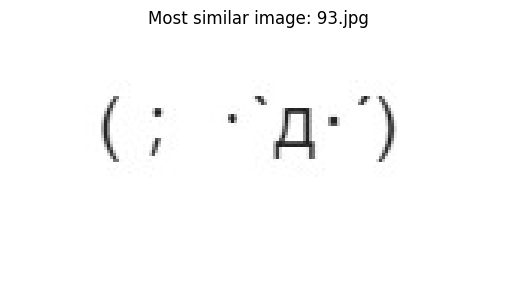

In [14]:
img = Image.open(highest_score_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Most similar image: {highest_score_image}")
plt.show()

In [15]:
import pandas as pd

# 讀取 CSV 檔案
file_path = 'match(68points).csv'
data = pd.read_csv(file_path)

# 尋找 'match' 欄位中第一個空白的位置
match_column = 'match'
first_empty_index = data[data[match_column].isna()].index.min()

if pd.isna(first_empty_index):
    # 如果沒有空白位置，則在末尾添加一行
    new_row = {match_column: highest_score_image, 'count': 0}  # 假設 'count' 應該是 0
    data = data.append(new_row, ignore_index=True)
else:
    # 在第一個空白位置插入圖片檔案名稱
    data.at[first_empty_index, match_column] = highest_score_image

# 儲存修改後的 CSV 檔案
data.to_csv(file_path, index=False)
import pandas as pd

# 讀取 CSV 檔案
file_path = 'Kaomoji.csv'  # 替換成您的 CSV 檔案路徑
kaomoji_data = pd.read_csv(file_path)

# 找到第一列中名字與 highest_score_image 相同的那一行
matching_row = kaomoji_data[kaomoji_data.iloc[:, 0] == highest_score_image]

# 如果找到相應的行，則顯示出來
if not matching_row.empty:
    print(matching_row)
else:
    print("No matching row found.")

# 提取第二列、第三列和第四列的值
eye_kao = matching_row.iloc[0]['eyes']  # Eye Size
emo_kao = matching_row.iloc[0]['emotion']  # Highest Emotion
mouth_kao = matching_row.iloc[0]['mouth']  # Mouth State

# 印出這些值以確認
print(f"Eye Size: {eye_kao}")
print(f"Emotion: {emo_kao}")
print(f"Mouth State: {mouth_kao}")
import pandas as pd

# 讀取 Human.csv 檔案
human_file_path = 'Human.csv'  # 替換為您的 CSV 檔案路徑
human_data = pd.read_csv(human_file_path)

# 找到名字與 image_path1 相同的那列
matching_human_row = human_data[human_data.iloc[:, 0] == image_path1]

# 如果找到相應的列，則提取第二列、第三列和第四列的值
if not matching_human_row.empty:
    # 提取第二列、第三列和第四列的值
    eye_hum = matching_human_row.iloc[0]['Eye Size']  # Eye Size
    emo_hum = matching_human_row.iloc[0]['Highest Emotion']  # Highest Emotion
    mouth_hum = matching_human_row.iloc[0]['Mouth State']  # Mouth State
else:
    eye_hum = emo_hum = mouth_hum = None  # 如果沒有匹配的列，則設為 None

# 您可以根據需要處理這些變數或印出它們
print(eye_hum, emo_hum, mouth_hum)
import pandas as pd

# 假定的匹配檔案名稱和 CSV 檔案路徑
match_file_path = 'match(68points).csv'

match_data = pd.read_csv(match_file_path)

# 初始化 count
count = 0

    # 如果值相同，則 count 加一
if eye_kao == eye_hum:
    count += 1
if emo_kao == emo_hum:
    count += 1
if mouth_kao == mouth_hum:
    count += 1

# 尋找 match(68points).csv 中第一個空白的 'count' 欄位
first_empty_index = match_data[match_data['count'].isna()].index.min()
match_data.at[first_empty_index, 'count'] = count

# 儲存更改
match_data.to_csv(match_file_path, index=False)


        id   eyes emotion mouth
92  93.jpg  small   angry  open
Eye Size: small
Emotion: angry
Mouth State: open
small happy close
